# Workflow of MUTIS (class version)

Here we illustrate the workflow of MUTIS (class version) to analyze correlation between two signals.
The general workflow is:

- **We load the data** in a suitable way.

- **We generate the synthethic light curves**, which are used to calculate the confidence levels of correlations.
    
    This is an automatic process if the method used for generating them is just **sampling** (lc_gen_samp), or flux randomization with the same **psd** (lc_gen_psd). If we simulate them as an **stochastic** process (lc_gen_ou) as suggested for example in Tavecchio, Bonnoli and Galanti, 2020 (doi:10.1093/mnras/staa2055) we need to carefully choose the parameters for this stochastic process (currently trying to optimize it).
    
- **We generate the correlations** (the synthethic ones and the real one) and plot them together.
    
    For this we need to manually choose the time binning.
    
In an effort to make the manual tasks as easy as possible I have incorporated new methods which automatically plot the results so the process of choosing this parameters is just a matter of executing one or two lines in the notebook and varying the numbers.

**Juan Escudero**

In [1]:
# I'm doing a lot of changes to MUTIS while writting this, better reload automatically.
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp

import pandas as pd
pd.set_option("display.max_columns", None)

from astropy.time import Time

import matplotlib as mplt
import matplotlib.pyplot as plt

from mutis.signal import Signal
from mutis.correlation import Correlation

## Load data
Load it with pandas becase I like the way pandas prints tables. Also useful accesing vars as strings!

In [3]:
data = {}

In [4]:
data['3mm'] = pd.read_csv('data/deg2-0235+164-3mm.dat', delim_whitespace=True, header=0, comment='!')
data['3mm'].mask(data['3mm'] == -1000, np.nan, inplace=True)

data['3mm']

,year,I,dI,pL,dpL,chi,dchi,pC,dpC,MJD
0,2007.3534,3.510,0.180,2.59,0.51,255.6,4.7,-0.58,0.22,54230.2015
1,2007.3671,3.920,0.200,2.61,0.47,245.2,5.0,-0.87,0.23,54234.8459
2,2007.6000,1.650,0.090,3.58,0.48,242.3,3.8,-0.35,0.22,54319.5631
3,2007.6356,1.380,0.070,2.49,0.54,268.5,4.5,0.31,0.22,54332.5276
4,2007.7041,0.690,0.040,3.27,0.54,250.7,4.1,-0.53,0.22,54358.4618
...,...,...,...,...,...,...,...,...,...,...
100,2020.4278,1.029,0.052,4.78,0.59,352.0,3.4,-3.80,0.42,59005.5950
101,2020.4542,2.216,0.111,4.38,0.58,347.6,3.2,0.33,0.31,59015.2792
102,2020.5063,2.226,0.111,1.21,0.47,320.0,12.2,1.00,0.31,59034.2958
103,2020.6671,2.234,0.112,7.18,0.67,311.8,1.8,1.35,0.33,59093.2050


In [5]:
data['gamma'] = pd.read_csv('data/0235_P8c_bin7_nov20.dat', delim_whitespace=True, header=0, comment='#')

data['gamma'].insert(0, 'year', value=Time(data['gamma']['MDJ'], format='mjd').jyear)

CFlux = np.where(np.logical_or(data['gamma']['UpperLimit'] == 'Ignored', data['gamma']['UpperLimit'] == 'Error'), 
                         data['gamma']['Flux'], data['gamma']['UpperLimit'])
data['gamma'].insert(2, 'CFlux', value=np.asarray(CFlux, dtype=np.float))

# Remove stupid data point
data['gamma'].drop(584, inplace=True)

data['gamma']

<ipython-input-5-b0fdef31e033>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data['gamma'].insert(2, 'CFlux', value=np.asarray(CFlux, dtype=np.float))


,year,N,CFlux,MDJ,Flux,Flux_Err,alpha,beta,Eb,UpperLimit,TS_VALUE,Norm,Norm_Err,T_START,T_STOP,NPRED
0,2008.605065,1,1.894027e-07,54687.5000,1.894027e-07,3.326300e-08,2.0803,0.095422,887.56,Ignored,120.40,2.714675e-11,4.769000e-12,239673599,240278399,116.30
1,2008.624230,2,5.572932e-07,54694.5000,5.572932e-07,4.754800e-08,2.0803,0.095422,887.56,Ignored,675.50,7.987585e-11,6.817000e-12,240278399,240883199,334.00
2,2008.643395,3,5.439230e-07,54701.5000,5.439230e-07,5.684800e-08,2.0803,0.095422,887.56,Ignored,500.00,7.795953e-11,8.150300e-12,240883199,241487999,253.10
3,2008.662560,4,6.763391e-07,54708.5000,6.763391e-07,6.980500e-08,2.0803,0.095422,887.56,Ignored,623.00,9.693850e-11,1.000800e-11,241487999,242092799,260.40
4,2008.681725,5,9.020173e-07,54715.5000,9.020173e-07,7.435100e-08,2.0803,0.095422,887.56,Ignored,994.10,1.292846e-10,1.066000e-11,242092799,242697599,362.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,2020.763861,15,1.119233e-07,59128.5001,1.119233e-07,5.747500e-08,2.0803,0.095422,887.56,Ignored,14.03,1.604177e-11,8.240300e-12,623376005,623980805,23.45
633,2020.783026,16,9.138770e-08,59135.5001,9.138770e-08,3.188800e-08,2.0803,0.095422,887.56,Ignored,21.53,1.309844e-11,4.571800e-12,623980805,624585605,37.80
634,2020.802191,17,6.064478e-08,59142.5001,2.843496e-08,1.657600e-08,2.0803,0.095422,887.56,6.064478E-08,7.04,4.075533e-12,2.376500e-12,624585605,625190405,12.19
635,2020.821356,18,4.770228e-08,59149.5001,4.770228e-08,2.429000e-08,2.0803,0.095422,887.56,Ignored,11.23,6.837084e-12,3.482500e-12,625190405,625795205,20.28


## Show data

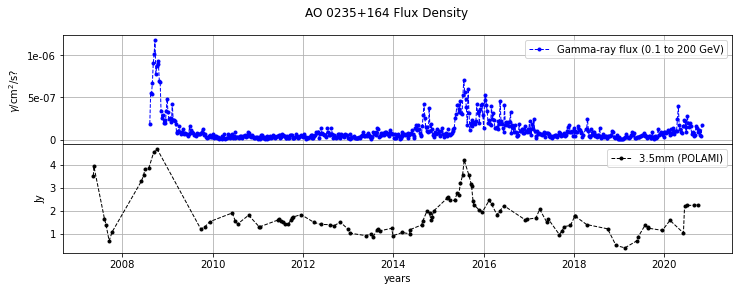

In [6]:
fig, ax = plt.subplots(nrows=2, figsize=(12,4), sharex=True, gridspec_kw={'hspace':0.00})


ax[0].plot(data['gamma']['year'], data['gamma']['CFlux'], 'b.--', label='Gamma-ray flux (0.1 to 200 GeV)', lw=1) # freq?
ax[0].set_ylabel('$\gamma/\mathrm{cm}^2/\mathrm{s}?$')
ax[0].legend()
import matplotlib.ticker as mtick; ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1g'))
ax[0].grid()

ax[1].plot(data['3mm']['year'], data['3mm']['I'], 'k.--', label='3.5mm (POLAMI)', lw=1)  #data['3mm'].plot(x='year', y='I')
ax[1].set_ylabel('Jy')
ax[1].legend()
ax[1].grid()

fig.suptitle('AO 0235+164 Flux Density')
plt.xlabel('years')
plt.show()

## Correlate data

### Choose data and methods

Choose the signals to correlate

In [7]:
t1, s1 = data['3mm']['year'], data['3mm']['I']
t2, s2 = data['gamma']['year'], 1e6*data['gamma']['CFlux'] ### ¡Use sensible units!

Create signals with the corresponding data and choose the method for generating the light curves.

In [8]:
sig1 = Signal(t1, s1, 'lc_gen_psd')
sig2 = Signal(t2, s2, 'lc_gen_ou')

Create the correlation with the corresponding signals and choose the method for generating the correltions.

In [9]:
correlation = Correlation(sig1, sig2, 'welsh_ab')

### Generate synthethic light curves

 **HUMAN INTERVENTION**
 
Chose good parameters for time binning!

Good parameters will have a high and similar $n_i$ for all bins, with bins covering most of the time range.

In [10]:
correlation.gen_times(dt0=0.25)

/Users/jer/git/MUTIS/mutis/correlation/core.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


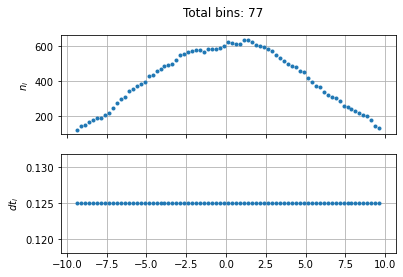

In [11]:
correlation.plot_times()

**HUMAN INTERVENTION**

If the method for generating the synthethic light curves is **lc_gen_ou** we need to chose a good set of parameters. 

In this case we have set only sig2's method to be lc_gen_ou because lc_gen_psd is more or less okey for sig1.

The Signal class includes methods to deal with this OU parameter extraction. This could be more or less an authomathic process, but for some (not a negible number of) cases degenerancy of these OU parameter makes human intervention necessary. We need:
1. To plot the histogram and check if the supposed probability density function (pdf) fits nicely (several ways: curve fitting or MLE).
2. To check if the stimates are reasonable and produce nice light curves.
3. Actually generate the light curves.

##### 1. Plot the histogram and get extracted parameters

/Users/jer/git/MUTIS/mutis/signal/core.py:165: RuntimeWarning: invalid value encountered in double_scalars
  return (ll * mu) ** (1 + ll) / scipy_special.gamma(1 + ll) * np.exp(-ll * mu / xx) / xx ** (ll + 2)
/opt/miniconda3/envs/mutis/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1790: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
/Users/jer/git/MUTIS/mutis/signal/core.py:165: RuntimeWarning: divide by zero encountered in true_divide
  return (ll * mu) ** (1 + ll) / scipy_special.gamma(1 + ll) * np.exp(-ll * mu / xx) / xx ** (ll + 2)
/Users/jer/git/MUTIS/mutis/signal/core.py:165: RuntimeWarning: invalid value encountered in true_divide
  return (ll * mu) ** (1 + ll) / scipy_special.gam

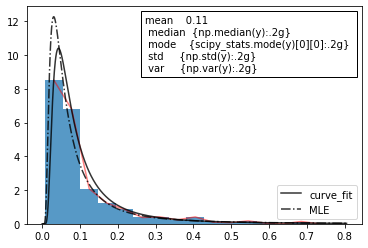

CPU times: user 28.7 s, sys: 413 ms, total: 29.1 s
Wall time: 29.2 s


In [12]:
%%time
fits = sig2.OU_fit()

In [13]:
fits

{'curve_fit': (array([1.00758579, 0.12887562]),
  array([0.17348046, 0.01219202])),
 'MLE_fit': (0.5523802491183334, 0.14125117915448523),
 'sigma_est': 5.9477164593388965,
 'th_est1': 9.770317097497758,
 'th_est2': 17.821840424447338}

##### 2. Check if this parameters generate nice light curves.

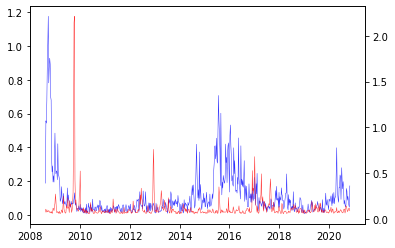

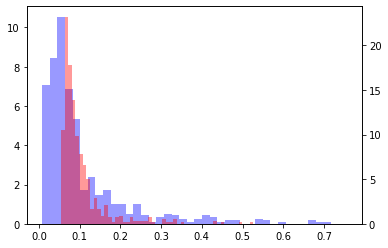

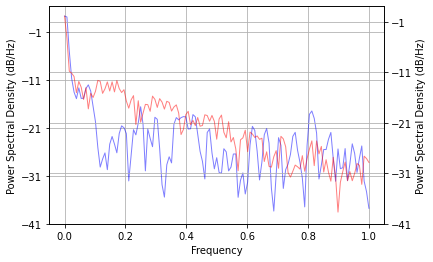

In [14]:
#%matplotlib inline
sig2.OU_check_gen(17, 1, 6)

**Set the parameters**

In [15]:
sig2.theta, sig2.mu, sig2.sigma = 17, 1, 6

##### 3. Actually generate the synthethic light curves

In [16]:
%%time
correlation.synth_gen(400)

CPU times: user 1min 8s, sys: 349 ms, total: 1min 8s
Wall time: 1min 9s


### Generate and plot correlations

In [17]:
%%time
correlation.gen_corr();

CPU times: user 18.3 s, sys: 250 ms, total: 18.5 s
Wall time: 18.7 s


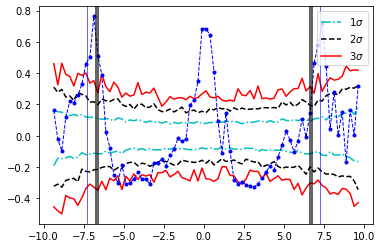

In [18]:
correlation.plot_corr()